##### Используемые библиотеки

In [2]:
import subprocess
import matplotlib.pyplot as plt
import numpy as np
import time

##### Параметры и константы

In [26]:
plt.style.use('seaborn-v0_8')

SOURCE_CODE_FILE_NAME = "Ex5"
EXECUTABLE_FILE_NAME = "Ex5"

FILTER_WINDOW_SIZE = 6
FILTER_THRESHOLD = 1.5
SHOW_FILTERED_VALUES = False

SHOW_O_N_LOG_N = False

##### Сборка C++ решения

In [6]:
build = subprocess.run(['g++', '-fopenmp' ,'-o', f'{EXECUTABLE_FILE_NAME}', f'{SOURCE_CODE_FILE_NAME}.cpp'], capture_output=True, text=True)
if (len(build.stderr) == 0):
    print('Build completed succesfully.')
else:
    print(build.stderr)

Build completed succesfully.


##### Выполнение сортировок

In [7]:
printAll = False
param = '' if printAll else '-once'
result = subprocess.run([f'./{EXECUTABLE_FILE_NAME}.exe', param], capture_output=True, text=True)
print(result.stdout)

start_time = time.time()
result = subprocess.run([f'./{EXECUTABLE_FILE_NAME}.exe', '-py'], capture_output=True, text=True)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Computation completed in: {elapsed_time:.4f} seconds")

lines = result.stdout.strip().split('\n')

result = {}
for line in lines:
    parts = line.split(',')
    key = parts[0]
    values = list(map(float, parts[1:]))
    
    if key == 'multithreaded':
        key = f"{key}_{int(values[1])}"
    if key == 'omp':
        key = f"{key}_{int(values[1])}"
    
    if key in result:
        result[key].append(values)
    else:
        result[key] = [values]

Sorting took 108.071 ms
Multithreaded sorting took 106.768 ms	[ threads: 1 ]	[ size: 100000 ]
Multithreaded sorting took 57.7606 ms	[ threads: 2 ]	[ size: 100000 ]
Multithreaded sorting took 43.8405 ms	[ threads: 3 ]	[ size: 100000 ]
Multithreaded sorting took 38.0048 ms	[ threads: 4 ]	[ size: 100000 ]
OpenMP sorting took 102.543 ms	[ threads: 1 ]	[ size: 100000 ]
OpenMP sorting took 98.3821 ms	[ threads: 2 ]	[ size: 100000 ]
OpenMP sorting took 65.0641 ms	[ threads: 3 ]	[ size: 100000 ]
OpenMP sorting took 54.4335 ms	[ threads: 4 ]	[ size: 100000 ]


Computation completed in: 71.7911 seconds


##### Скользящий медианный фильтр
Избавляется от некоторых артефактов в вычислениях заменяя их на медианное значение

In [27]:
corrected_items = []

def rolling_median_filter(data):
    filtered_data = data.copy()

    for i in range(1, len(data) - 1):
        window_start = max(0, i - FILTER_WINDOW_SIZE // 2)
        window_end = min(len(data), i + FILTER_WINDOW_SIZE // 2 + 1)
        local_median = np.median(data[window_start:window_end])
        
        if abs(data[i] - local_median) > FILTER_THRESHOLD:
            corrected_items.append((i, float(filtered_data[i]), float(local_median)))
            filtered_data[i] = local_median 
    
    return filtered_data

def smooth_first_value(data):
    first_values = [item[0] for item in data]
    
    smoothed_first_values = rolling_median_filter(np.array(first_values))
    
    for i in range(len(data)):
        data[i][0] = smoothed_first_values[i]
    
    return data

for key, values in result.items():
    result[key] = smooth_first_value(values)

if (SHOW_FILTERED_VALUES):
    print(f'Corrected elements ({len(corrected_items)}):')
    for item in corrected_items:
        print(item)
else:
    print(f'Corrected elements ({len(corrected_items)})')



Corrected elements (1)


##### Графики времени выполнения сортировки в зависимости от алгоритма и количества элементов в коллекции

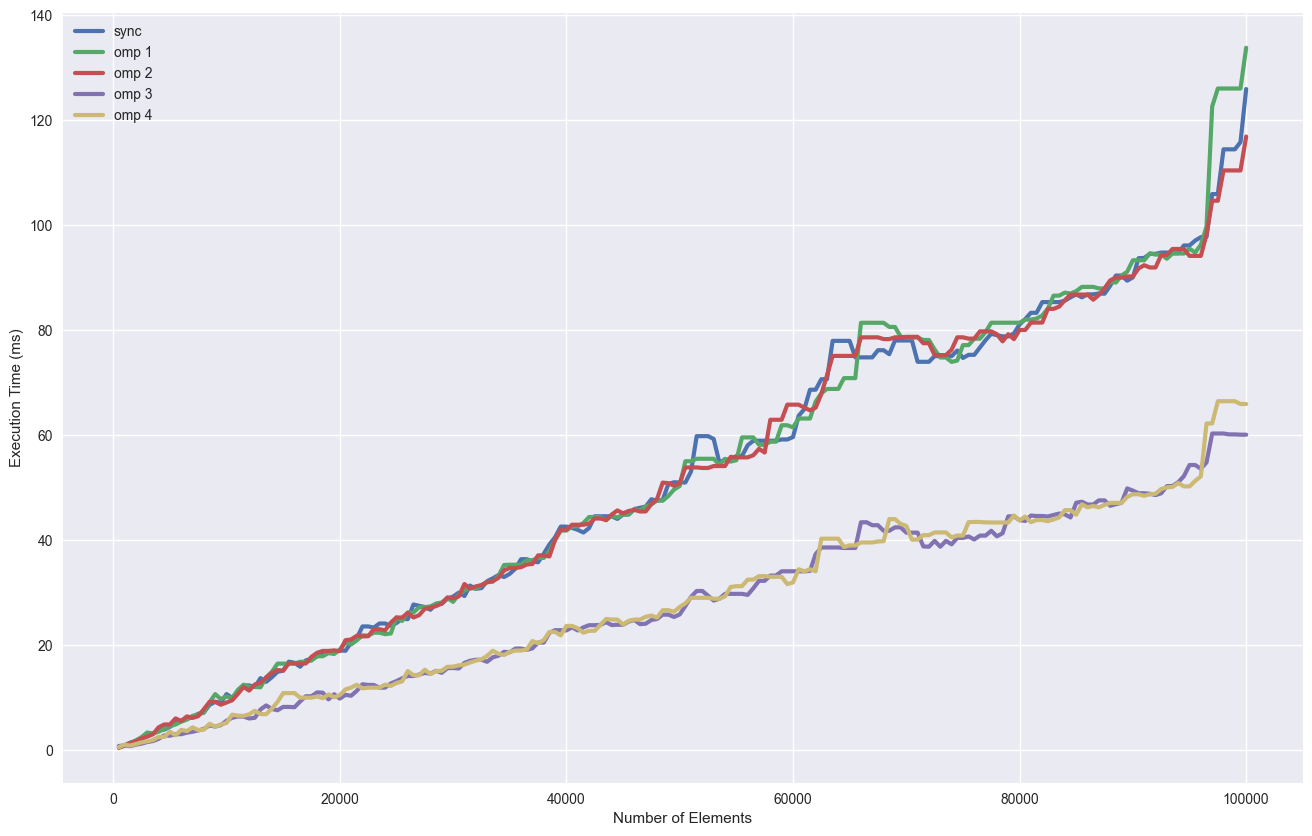

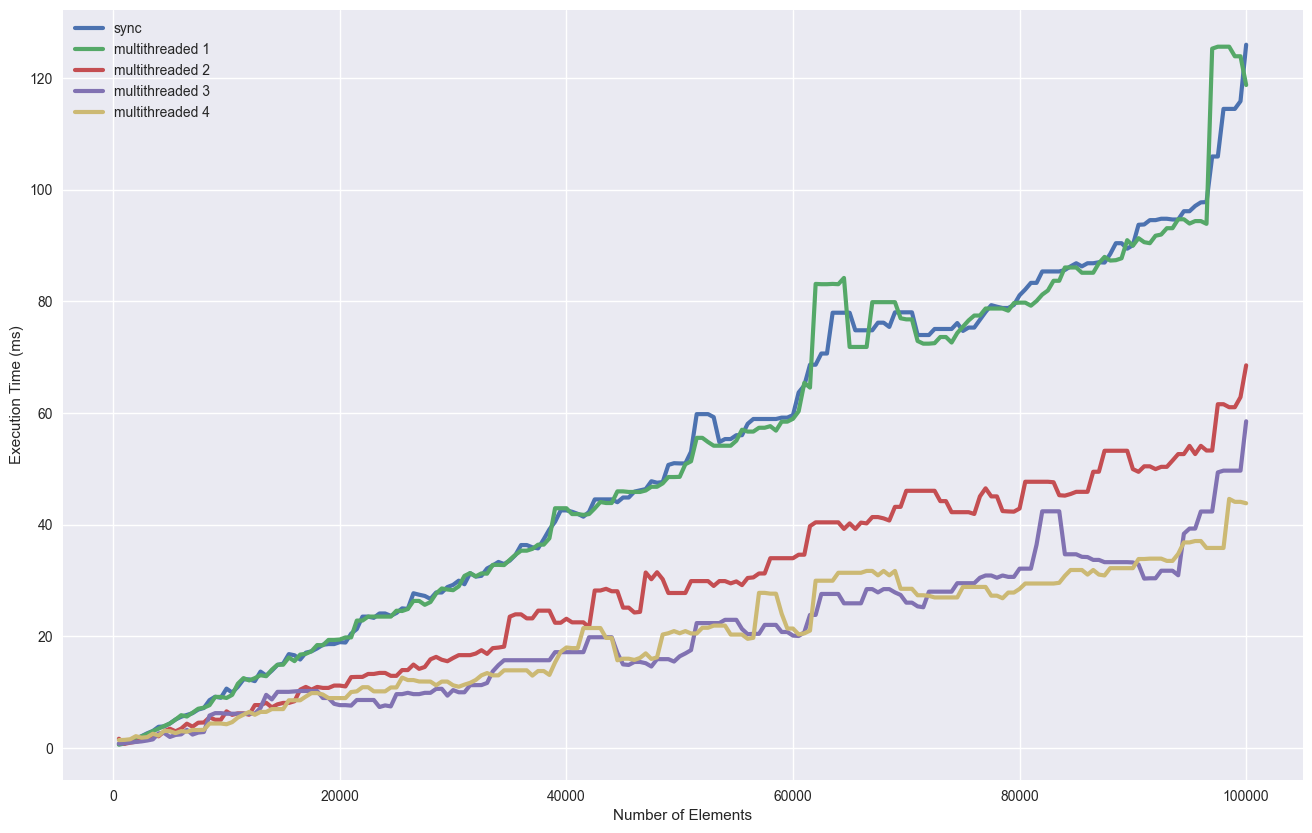

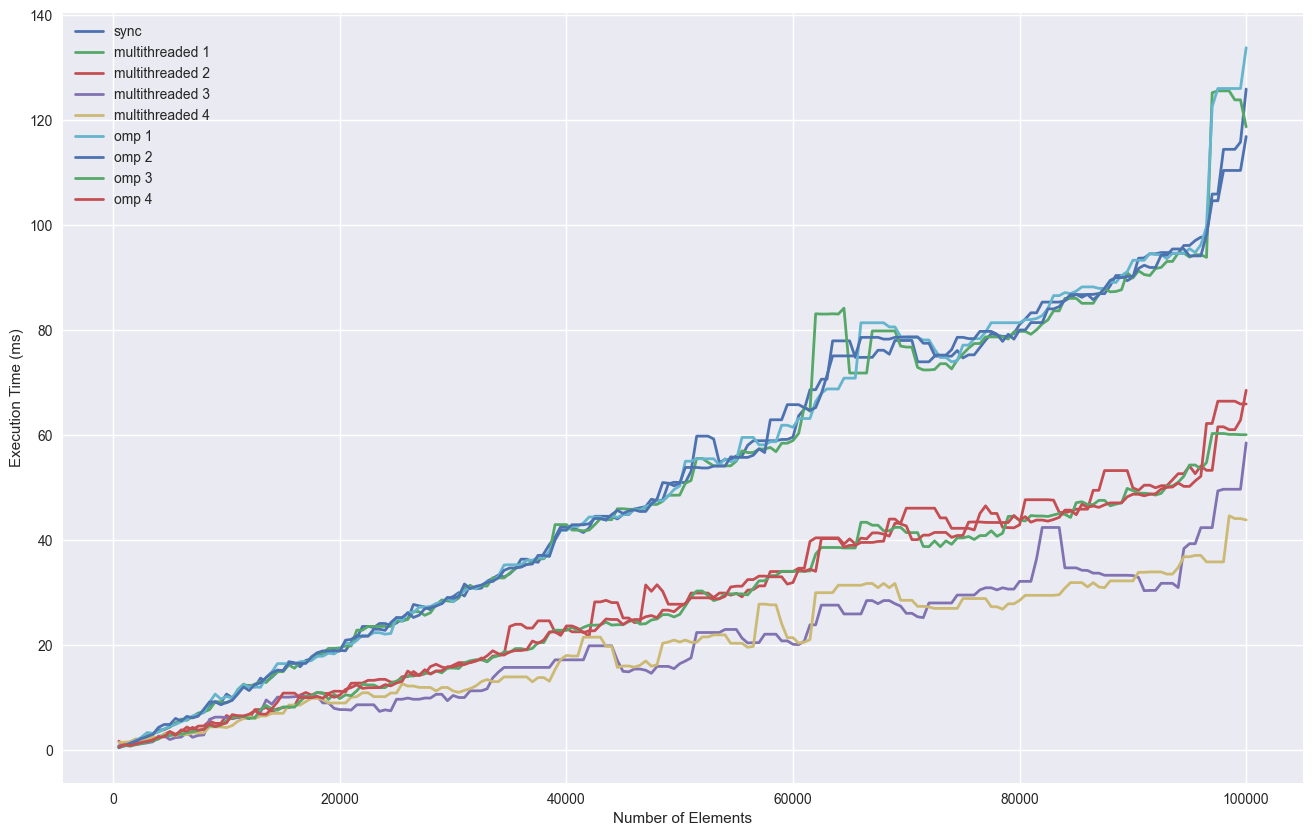

In [28]:
plot_data = {}
for key, values in result.items():
    x = [v[2] for v in values]
    y = [v[0] for v in values]
    plot_data[key] = (x, y)

plt.figure(figsize=(16, 10))
for key, (x, y) in plot_data.items():
    if (str(key).count('omp') != 0  or str(key) == "sync"):
        plt.plot(x, y, label=key.replace('_', ' '), linewidth = 3, alpha = 1)
plt.xlabel('Number of Elements')
plt.ylabel('Execution Time (ms)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(16, 10))
for key, (x, y) in plot_data.items():
    if (str(key).count('multithreaded') != 0 or str(key) == "sync"):
        plt.plot(x, y, label=key.replace('_', ' '), linewidth = 3, alpha = 1)
plt.xlabel('Number of Elements')
plt.ylabel('Execution Time (ms)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(16, 10))
for key, (x, y) in plot_data.items():
    plt.plot(x, y, label=key.replace('_', ' '), linewidth = 2, alpha = 1)

if (SHOW_O_N_LOG_N):
    n_values = np.linspace(min(x), max(x), 300)
    n_log_n_values = n_values * np.log(n_values)
    max_y = max(max(y) for _, y in plot_data.values())
    min_y = min(min(y) for _, y in plot_data.values())
    n_log_n_values = (n_log_n_values - min(n_log_n_values)) / (max(n_log_n_values) - min(n_log_n_values)) * (max_y - min_y) + min_y
    plt.plot(n_values, n_log_n_values, label='O(n log n)', linestyle='--', color='black')

plt.xlabel('Number of Elements')
plt.ylabel('Execution Time (ms)')
plt.legend()
plt.grid(True)
plt.show()


##### График сравнения времени выполнения каждого из алгоритмов в % от синхронного решения

multithreaded_1 is 0.06% faster than sync.
multithreaded_2 is 43.99% faster than sync.
multithreaded_3 is 61.00% faster than sync.
multithreaded_4 is 61.51% faster than sync.
omp_1 is -1.04% faster than sync.
omp_2 is 0.29% faster than sync.
omp_3 is 46.48% faster than sync.
omp_4 is 45.76% faster than sync.


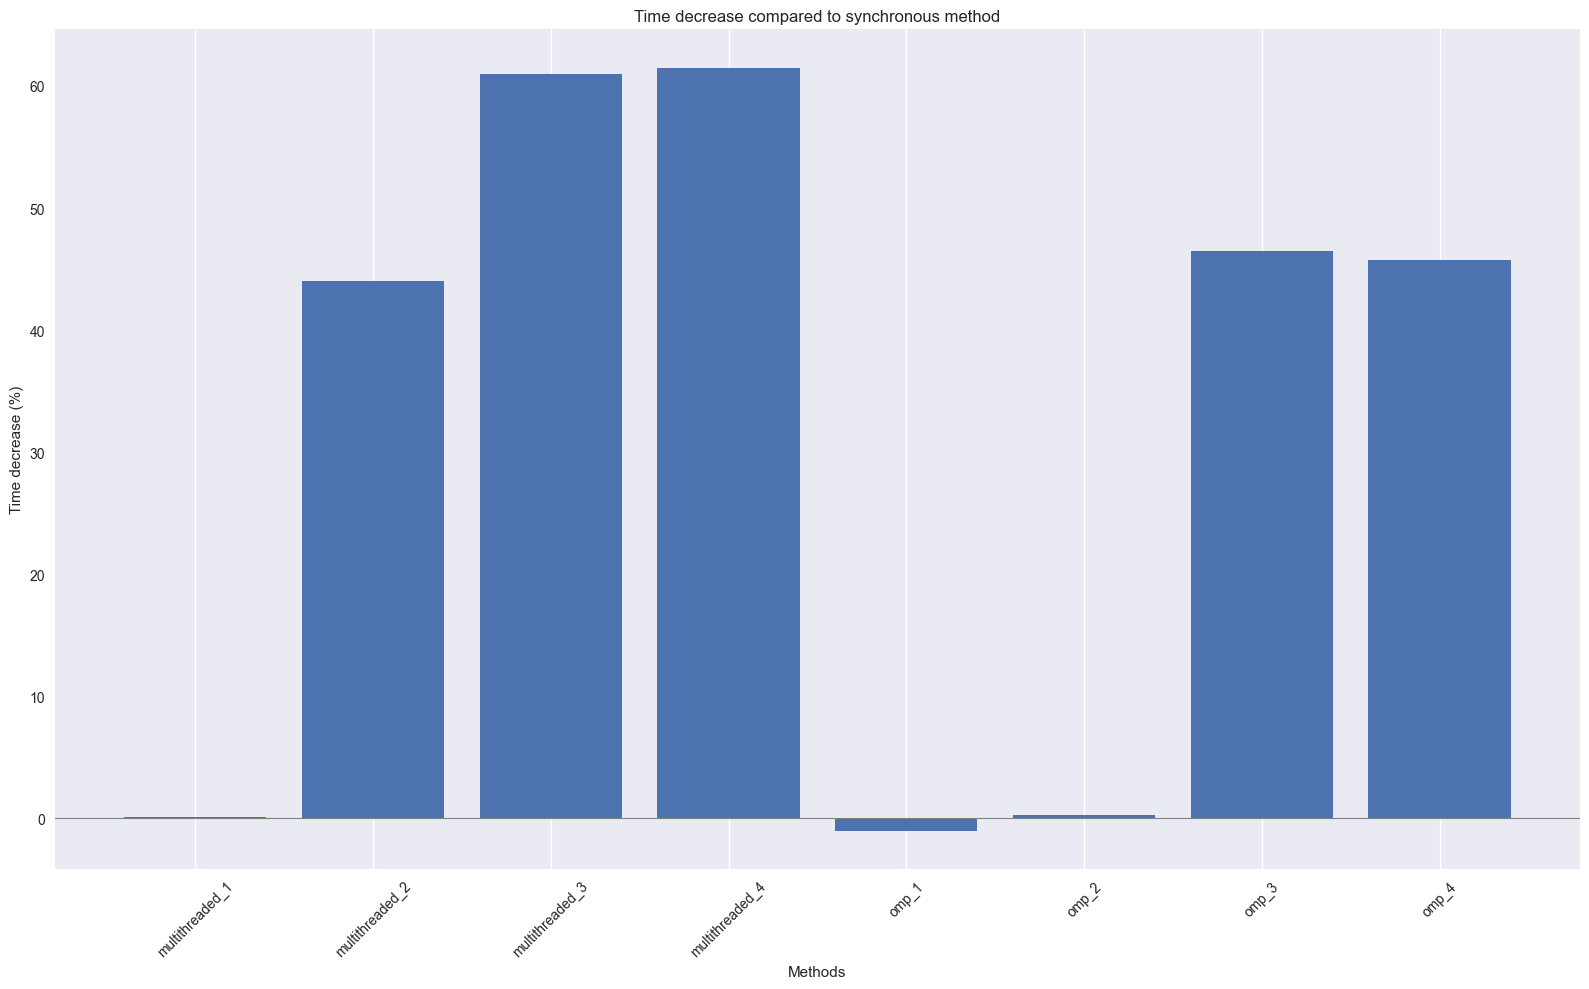

In [29]:
def calculate_total_percentage_decrease(data):
    sync_times = [entry[0] for entry in data['sync']]

    average_sync_time = sum(sync_times) / len(sync_times)

    total_percentage_decrease = {}

    for method, times in data.items():
        if method == 'sync':
            continue

        method_times = [entry[0] for entry in times]

        average_method_time = sum(method_times) / len(method_times)

        if average_sync_time == 0:
            decrease = 0.0
        else:
            decrease = ((average_sync_time - average_method_time) / average_sync_time) * 100

        total_percentage_decrease[method] = float(decrease)

    return total_percentage_decrease

total_percentage_decrease = calculate_total_percentage_decrease(result)

for method, decrease in total_percentage_decrease.items():
    print(f"{method} is {decrease:.2f}% faster than sync.")

methods = list(total_percentage_decrease.keys())
decreases = list(total_percentage_decrease.values())

plt.figure(figsize=(16, 10))
plt.bar(methods, decreases)
plt.axhline(0, color='gray', linewidth=0.8)
plt.title('Time decrease compared to synchronous method')
plt.xlabel('Methods')
plt.ylabel('Time decrease (%)')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.tight_layout()
plt.show()